AlexNet in PyTorch
===

Most of the code are derivated from [examples/imagenet](https://github.com/pytorch/examples/tree/master/imagenet) and [torchvision/models/alexnet.py](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py).

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Slide: [AlexNet in PyTorch](https://docs.google.com/presentation/d/1EtflA3HRTNEQ5Yj5YKW6KOZ5it4HOHeDkztYbZQf-pw/edit?usp=sharing)


In [1]:
import os

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 載入圖片資料

In [2]:
## Load data
data_dir = '.\\tiny-imagenet-200'

traindir = os.path.join(data_dir, 'train')
valdir = os.path.join(data_dir, 'val')
augmentation = transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[1, 1, 1])
               ])
val_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[1, 1, 1])
               ])

train_dataset = datasets.ImageFolder(traindir, augmentation)
val_dataset = datasets.ImageFolder(valdir, val_transform)

### 初始化 DataLoader

In [3]:
## Prepare dataloader
batch_size = 128
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True)

### 定義網路結構

In [4]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=200):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(5),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(5),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

## Init network
model = AlexNet()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

### Loss function 及 Optimizer 定義

In [5]:
# Hyper parameters
lr = 0.01
momentum = 0.9
weight_decay = 0.0005

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

# Get GPU
is_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if is_gpu else "cpu")
if is_gpu:
    model.to(device)
    criterion.to(device)

### 輔助函式

`accuracy` 爲計算 top 1 及 top 5 precision

`AverageMeter` 爲輔助記錄整體精確度的物件

In [6]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res
            
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Train function

In [7]:
## Train epoch
def train(train_loader, model, criterion, optimizer, is_gpu, device, epoch):
    # Metrics
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    model.train()

    for i, (input, target) in enumerate(train_loader):
        # Move input and target to GPU if abailable
        if is_gpu:
            input, target = input.to(device), target.to(device)

        # Feed forward
        output = model(input)
        loss = criterion(output, target)

        # Metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # Backprop and SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print every 100 batch
        if i % 100 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   epoch, i, len(train_loader), loss=losses, top1=top1, top5=top5))

### Validate function

In [8]:
## Validate
def validate(val_loader, model, criterion, is_gpu, device):
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            if is_gpu:
                input, target = input.to(device), target.to(device)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(prec1[0], input.size(0))
            top5.update(prec5[0], input.size(0))

        print('VALIDATE Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

### 開始訓練！

In [9]:
## Training
impv_prec1 = 0
prev_prec1 = 0
epochs = 1
for epoch in range(epochs):
    train(train_loader, model, criterion, optimizer, is_gpu, device, epoch)
    prec1 = validate(val_loader, model, criterion, is_gpu, device)

    impv_prec1 += prec1 - prev_prec1
    prev_prec1 = prec1

    # Check acc improvement every 10 epoch
    if epoch % 10 == 9:
        if impv_prec1 < 1.0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        print('CHECK_IMPROVE Epoch: {}, Prec1 imporve: {:.3f}, lr: {:.4f}'.format(epoch, impv_prec1, lr))
        impv_prec1 = 0

Epoch: [0][0/782]	Loss 5.2992 (5.2992)	Prec@1 0.781 (0.781)	Prec@5 2.344 (2.344)
Epoch: [0][100/782]	Loss 5.2992 (5.2985)	Prec@1 0.000 (0.580)	Prec@5 2.344 (2.328)
Epoch: [0][200/782]	Loss 5.2978 (5.2985)	Prec@1 0.000 (0.517)	Prec@5 2.344 (2.418)
Epoch: [0][300/782]	Loss 5.2974 (5.2986)	Prec@1 0.000 (0.498)	Prec@5 3.906 (2.333)
Epoch: [0][400/782]	Loss 5.2996 (5.2986)	Prec@1 0.000 (0.477)	Prec@5 2.344 (2.316)
Epoch: [0][500/782]	Loss 5.2992 (5.2987)	Prec@1 0.000 (0.493)	Prec@5 0.781 (2.314)
Epoch: [0][600/782]	Loss 5.2992 (5.2987)	Prec@1 0.781 (0.482)	Prec@5 2.344 (2.297)
Epoch: [0][700/782]	Loss 5.2993 (5.2988)	Prec@1 1.562 (0.471)	Prec@5 2.344 (2.277)
VALIDATE Prec@1 0.500 Prec@5 2.680


### 載入訓練好的 Model

In [10]:
## Load model
checkpoint = torch.load('model_best.pth')
model.load_state_dict(checkpoint['state_dict'])
model.to('cpu')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

### 載入 Label 資訊

In [11]:
## Load labels
from collections import defaultdict
wnids = []
words = defaultdict(str)
with open('wnids.txt', 'r') as f:
    for line in f:
        wnids.append(line.strip('\n'))
wnids = sorted(wnids)
with open('words.txt', 'r') as f:
    for line in f:
        sp = line.strip('\n').split('\t', 1)
        wnid = sp[0]
        word = sp[1]
        if wnid in wnids:
            words[wnid] = word

### 隨機挑選測試圖片

In [12]:
## Load image and make prediction
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

PRED1: brown bear, bruin, Ursus arctos
PRED2: bison
PRED3: golden retriever
PRED4: lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
PRED5: ox


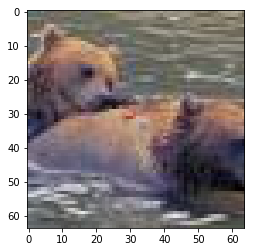

In [13]:
rand_id = np.random.randint(1000)
image = Image.open(os.path.join('tiny-imagenet-200', 'test', 'images', 
                               'test_{}.JPEG'.format(rand_id)))
plt.imshow(image)

with torch.no_grad():
    output = model(val_transform(image).unsqueeze(0)).numpy()[0]
    top5_cate = output.argsort()[::-1][:5]
    
    for i, cate in enumerate(top5_cate):
        print('PRED'+str(i+1)+': '+words[wnids[cate]])